# Topics

## 1. Fourier Descriptor  
## 2. The Order of the Points Matters
## 3. Contours
## 4. Meaning the FD's, order by order

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
from pdb import set_trace
from copy import copy

import matplotlib.image as mpimg

In [2]:
'''
Breakout Solution from last time

Useful functions

'''

def FD(x, y, plot_FD = False, y_lim = None):

    N = len(x)
    z = x + y*1j

    Z = np.fft.fft(z)
        
    # For very noisy data d would appear longer than the 
    # the actual separation between 2 adjacent points for the
    # "true" shape underneath.
    d_complex = np.gradient(z)
    d = np.abs(d_complex).mean()
    print('Average distance bewteen adjacent points:{}'.format(d))
    
    
    print('Spatial interval: {:.4f}'.format(d))
    k = np.fft.fftfreq(len(z), d = d)
    k_lo = np.abs(k[np.argsort(np.abs(k))][1])

    if plot_FD:
        plt.figure()
        plt.title('FD real')
        plt.plot(k, Z.real, 'b.')
        plt.xlabel('k')
        plt.ylabel('Re[FD]')
        if y_lim != None:
            plt.ylim([-y_lim, y_lim])
        plt.figure()
        plt.title('FD imag')
        plt.plot(k, Z.imag, 'g.')
        plt.xlabel('k')
        plt.ylabel('Im[FD]')
        if y_lim != None:
            plt.ylim([-y_lim, y_lim])

    return Z, k, k_lo

def filt_FD(Z, k, k_keep): #, no_zeroth = True):

    filt = np.abs(k) <= k_keep
    print("FD components kept:", filt.sum())
    return Z*filt, k*filt



def recover_shape(Z):
    z_rec = np.fft.ifft(Z)

    x_rec = z_rec.real
    y_rec = z_rec.imag
    
    return x_rec, y_rec


def plot_shape(x, y, plot_style = 'b.'):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(111)  
    ax.set_title('Recovered Shape')
    try:
        xlen = len(x)
    except:
        ax.plot(x, y, plot_style)
    else:
        for i in range(xlen):
            ax.plot(x[i], y[i], plot_style)


## The Letter E

<function matplotlib.pyplot.show>

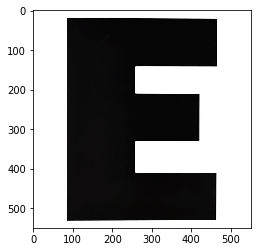

In [3]:
im = mpimg.imread('letterE.jpg')
plt.imshow(im)
plt.show

In [4]:
'''
Breakout3 Solution from last time

'''

def extract_shape_v0(im_file, blowup = 1., plot_img = False, plot_contour = False, plot_contour_pts = False):

    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    import numpy as np
    from skimage import feature
    
    im = mpimg.imread(im_file)
    # Take one of RGB(A) channels
    if len(im.shape) > 2:
        im = im[:, :, 0]
    
    if plot_img:
        plt.figure()
        plt.title('Original Shape')
        plt.imshow(im, cmap = plt.cm.gray)

    x = np.arange(im.T.shape[0])*blowup  
    y = np.arange(im.T.shape[1])*blowup
    
    # Have to flip y to get the orientation right, again just a peculiar convention we have to work around
    # Note the [::] notation: a[3:20:2] means from the 3rd element to the 20th element, choose every 2nd element.
    y = y[::-1]

    # In case I want to shift x.
    #x_shift = 200
    #x += x_shift

    X, Y = np.meshgrid(x, y)
    
    plt.figure()
    plt.title('Contours')
    # Note the dimensions of x and y may NOT the same, thus the necessity of the 
    # tranpose operation (an oddity, I admit...)
    CS = plt.contour(X, Y, im, 1)
    levels = CS.levels
    print('contour level', levels)
    if not plot_contour:
        plt.close()

    cs_paths = CS.collections[0].get_paths()

    print('number of contour path', len(cs_paths))

    p = cs_paths[0]
    v = p.vertices
    x_arr = v[:,0]
    y_arr = v[:,1]

    if plot_contour_pts:
        plt.figure()
        plt.title("Verify the contour points are correct")
        plt.plot(x_arr, y_arr)

    return x_arr, y_arr

contour level [ 150.]
number of contour path 1


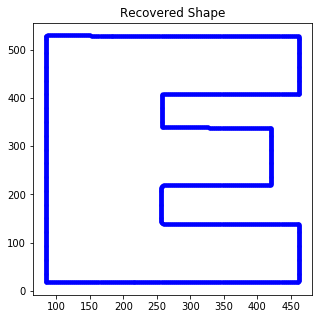

In [5]:
'''Test to see if the function extract_shape_v0() works'''
x, y = extract_shape_v0('letterE.jpg')
plot_shape(x, y)


contour level [ 150.]
number of contour path 1
Average distance bewteen adjacent points:0.9953126687152395
Spatial interval: 0.9953
Total number of points (N): 2515
FD components kept: 21
len(Z_filt) 2515
[ 3.9628702   1.88984921  0.89535545  0.16641311  0.38832016  0.17207458
  0.06237048  0.06065311  0.04797243  0.06401696  0.00705977  0.06022795
  0.05483663  0.06954512  0.04004549  0.07584656  0.09554104  0.34255907
  0.05264279  0.17081624  0.52914275]


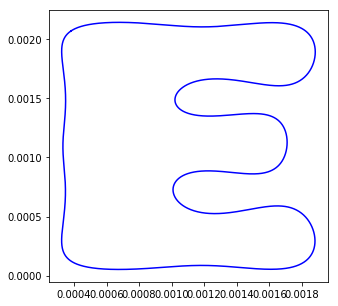

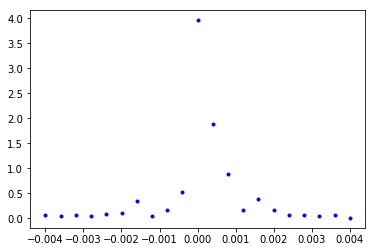

In [7]:
'''
Breakout 4 Solution from last time
'''

def size_norm(Z):
    return Z/np.sqrt( np.abs(Z[1])*np.abs(Z[-1]) )


def get_FD_abs(x, y, order = 10, norm = True):
    '''Finds the Fourier Descriptors and the recovered x and y for a shape.'''
    Z, k, k_lo = FD(x, y)
    N = len(x)
    print('Total number of points (N):', N)

    Z_filt, k_filt = filt_FD(Z, k, order*k_lo)
    if norm:
        Z_filt = size_norm(Z_filt)
    print('len(Z_filt)', len(Z_filt))
    x_rec, y_rec = recover_shape(Z_filt)

    # throw away zero terms
    fd_mag = np.abs(Z_filt[Z_filt != 0])
    k_kept = k[Z_filt != 0]
    #     fd_mag = fd_mag[fd_mag > 0]
    
    return fd_mag, k_kept, x_rec, y_rec

order = 10
x, y = extract_shape_v0('letterE.jpg')
# fd, x_rec, y_rec = get_FD_abs(x, y, order = order, norm = False, no_zeroth = True)
fd, k_kept, x_rec, y_rec = get_FD_abs(x, y, order = order)

plt.figure(figsize = (5, 5))
plt.plot(x_rec, y_rec, 'b')

plt.figure()
plt.plot(k_kept, fd, 'b.')
# plt.plot(np.arange(2, 2*order), fd[1:-1], 'bo')
# print(len(np.arange(2, 2*order)), len(fd[1:-1]))
plt.show()

## What's All This Good for??
## Shape recognition regardless of location, size or orientation!
## Breakout Exercise: use get_FD_abs() to find and then plot the magnitudes of the first 5 FD's for the letter E and H.

contour level [ 150.]
number of contour path 1
contour level [ 150.]
number of contour path 1
Average distance bewteen adjacent points:0.9953126687152395
Spatial interval: 0.9953
Total number of points (N): 2515
FD components kept: 21
len(Z_filt) 2515
Average distance bewteen adjacent points:0.9930123145744244
Spatial interval: 0.9930
Total number of points (N): 2713
FD components kept: 21
len(Z_filt) 2713


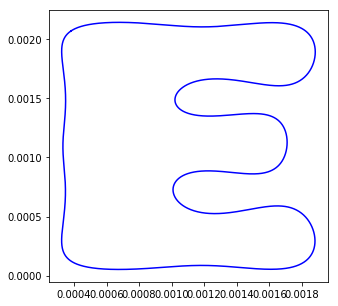

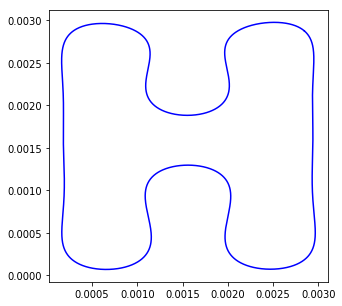

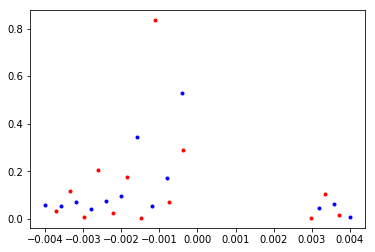

In [23]:
order = 10
xe, ye = extract_shape_v0('letterE.jpg')
xh, yh = extract_shape_v0('letterH.jpg')
fde, k_kepte, x_rece, y_rece = get_FD_abs(xe, ye, order = order)
fdh, k_kepth, x_rech, y_rech = get_FD_abs(xh, yh, order = order)

plt.figure(figsize = (5, 5))
plt.plot(x_rece, y_rece, 'b')

plt.figure(figsize = (5, 5))
plt.plot(x_rech, y_rech, 'b')

plt.figure()
plt.plot(k_kepte[8:24], fde[8:24], 'b.')
plt.plot(k_kepth[8:24], fdh[8:24], 'r.')

plt.show()
    

## Final Word: This is a blunt way of achieving roational invariance.  For numbers and letters with sharp edges (i.e., very little noise) this maybe good enough.  

## But For more complicated shapes, you may run into the issue of degeneracy -- two or more distinct shapes having the same |FD|'s.  

## Then you'd want to keep the phase and for each shape, try all possible orientations and see if one of them fits.  This falls into a category of problems knowns as "least square fit", which we will get into in CP II.

## FD offers the first step in shape recognition regardless of location, size or orientation
## ...the beginning of computer vision!

## Short Breakout: Find out what  whatsthis.png is by looking at its reconstruction from 5, 10, 15, 20, 25, 30, 100, 1000 FD's

## How many FD's do you need to recognize the shape?  (This is one way to compress data: instead of saving pixels, you save their FD's)

contour level [ 0.5]
number of contour path 5
Average distance bewteen adjacent points:0.7780767951358704
Spatial interval: 0.7781
Total number of points (N): 4429
FD components kept: 11
len(Z_filt) 4429


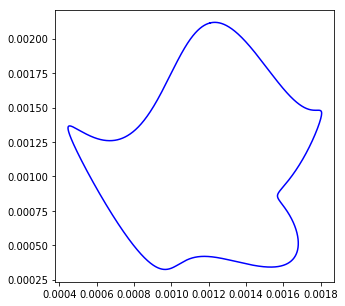

In [33]:
order = 5
x, y = extract_shape_v0('whatsthis.png')

fd, k_kept, x_rec, y_rec = get_FD_abs(x, y, order = order)

plt.figure(figsize = (5, 5))
plt.plot(x_rec, y_rec, 'b')

## End of week11-3